## Primeras pruebas en la exploración del catálogo GAIA DR3


#### Requirements

In [1]:
%load_ext autoreload
%autoreload 2
    
import sys
import os

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
    
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.heasarc import Heasarc

from src.gaia_dr3.etls.download_data import get_object, get_object_from_simbad, get_cluster
from src.gaia_dr3.etls.stadistics import get_uwe_from_gaia, get_u0_g_c, get_ruwe_from_gaia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 
Gaia.ROW_LIMIT = -1

In [5]:
job = Gaia.launch_job("select top 100 "
                      "*"
                      "from gaiadr3.gaia_source order by source_id")
r = job.get_results()
print(r['ra_dec_corr'])

ra_dec_corr 
------------
  0.12293493
  0.16325329
   0.1152631
  0.03106277
 0.090631574
  0.25799984
  0.15041357
  0.15176746
  0.19033876
  0.18675442
         ...
-0.047490653
  0.18519369
  0.11701631
  0.14461127
  0.05615686
  0.26646927
-0.019807748
  0.81679803
 -0.07291612
 -0.12864673
Length = 100 rows


In [36]:
heasarc = Heasarc()
table = heasarc.query_mission_list()
df = table.to_pandas()
df[df.Mission == "STAR CATALOG"].Table.values

array(['aavsovsx', 'acrs', 'asiagosn', 'atnfpulsar', 'batsepulsr',
       'bestars', 'bnmdspecat', 'bsc5p', 'chanvguide', 'chasfrxray',
       'cns3', 'cocd', 'cocdext1', 'corotexlog', 'cpstars', 'crabtime',
       'cvcat', 'dncvobcat', 'duerbeck', 'exoplanets', 'exoplanodb',
       'flarestars', 'galobstars', 'gcvs', 'gcvsegvars', 'gcvsnsvars',
       'gliese2mas', 'globclust', 'goscat', 'hbc', 'hdec', 'hic',
       'hipnewcat', 'hipparcos', 'hmxbcat', 'hmxbcat2', 'hyadesxray',
       'intomcvs', 'ipclxlbol', 'ipcostars', 'lmcclustrs', 'lmcextobj',
       'lmxbcat', 'lspmnorth', 'lyngaclust', 'm31clustrs', 'm31rbcgc',
       'm31stars', 'm31stars2', 'macs', 'maghmxbcat', 'mcksion',
       'mdwarfasc', 'mdwf10pcux', 'morbbincat', 'mwsc', 'mystixires',
       'mystixmpcm', 'newmdwarfs', 'ngc6530oid', 'nltt', 'nuvbemdcat',
       'openclust', 'orionxray', 'orionxstar', 'oriysoir', 'ostars', 'pg',
       'pleiadxray', 'pmpulsar', 'pmsucat', 'ppm', 'ppmxlbmd', 'pulsar',
       'rassasaseb'

In [17]:
from astroquery.heasarc import Heasarc
COLUMNS = ['NAME','ALT_NAME','RA','DEC','VMAG','BV_COLOR','HELIO_DISTANCE','METALLICITY','CORE_RADIUS', 'HALF_LIGHT_RADIUS']

heasarc = Heasarc()
mission = 'globclust'
table = heasarc.query_object("ngc104", mission=mission, resultmax=10,  fields=",".join(COLUMNS))
table

NAME,ALT_NAME,RA,DEC,VMAG,BV_COLOR,HELIO_DISTANCE,METALLICITY,CORE_RADIUS,HALF_LIGHT_RADIUS,SEARCH_OFFSET_
,,deg,deg,mag,mag,kpc,,arcmin,arcmin,
bytes9,bytes11,float64,float64,float64,float64,float64,float64,float64,float64,bytes15
NGC 104,47 Tuc,6.02363,-72.08128,3.95,0.88,4.5,-0.72,0.36,3.17,0.026 (ngc104)\n


In [2]:
Gaia.ROW_LIMIT = -1
results = get_cluster("ngc104", rc_scale=1.0)
results6 = get_cluster("ngc104", rc_scale=6.0)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
df_rc1 = results.to_pandas()
df_rc6 = results6.to_pandas()

print(f"Rc1: {df_rc1.shape[0]} elementos")
print(f"Rc6: {df_rc6.shape[0]} elementos")

df_rc1["RUWE_np5"] = get_ruwe_from_gaia(df_rc1, 5)
df_rc1["RUWE_np6"] = get_ruwe_from_gaia(df_rc1, 6)

df_rc6["RUWE_np5"] = get_ruwe_from_gaia(df_rc6, 5)
df_rc6["RUWE_np6"] = get_ruwe_from_gaia(df_rc6, 6)

Rc1: 85 elementos
Rc6: 5776 elementos


In [4]:
mask_ruwe =  df_rc6.RUWE_np5 < 1.4
df_rc6[mask_ruwe]

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist,RUWE_np5,RUWE_np6
377,1636148068921376768,Gaia DR3 4689639193822057472,4689639193822057472,1418306720,2016.0,6.027121,0.020151,-72.092849,0.019172,0.160192,...,1.0557,0.9739,1.0851,0.5593,0.5151,0.5753,PHOENIX,0.011620,1.189967,0.935773
408,1636148068921376768,Gaia DR3 4689639301203689728,4689639301203689728,338375145,2016.0,6.061602,0.011961,-72.079030,0.012424,0.200503,...,1.3394,1.3230,1.3771,0.7103,0.7011,0.7308,PHOENIX,0.011901,1.122959,0.788697
442,1636148068921376768,Gaia DR3 4689639232484222464,4689639232484222464,832516425,2016.0,6.060353,0.018805,-72.085919,0.020180,0.173894,...,NaN,NaN,NaN,NaN,NaN,NaN,,0.012216,1.233065,0.862769
467,1636148068921376768,Gaia DR3 4689639266844818048,4689639266844818048,525224996,2016.0,5.999296,0.013813,-72.091256,0.012906,0.212783,...,NaN,NaN,NaN,NaN,NaN,NaN,,0.012471,0.824799,0.693795
525,1636148068921376768,Gaia DR3 4689639193822065920,4689639193822065920,25670769,2016.0,6.042818,0.024460,-72.092805,0.019327,0.213234,...,0.6252,0.1518,0.6913,0.3258,0.0781,0.3622,MARCS,0.012951,1.370805,1.129092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,1636148068921376768,Gaia DR3 4689638781505129216,4689638781505129216,1721597212,2016.0,5.909056,0.011838,-72.077641,0.014836,0.220523,...,NaN,NaN,NaN,NaN,NaN,NaN,,0.035438,1.052704,0.966393
5616,1636148068921376768,Gaia DR3 4689637956871413376,4689637956871413376,1312085600,2016.0,5.917527,0.014004,-72.095170,0.017337,0.203325,...,0.2489,0.2452,0.2548,0.1344,0.1324,0.1376,MARCS,0.035463,1.167842,1.140961
5623,1636148068921376768,Gaia DR3 4689627515811200128,4689627515811200128,896868603,2016.0,6.129324,0.017099,-72.095499,0.022762,0.129999,...,0.5042,0.4848,0.5866,0.2727,0.2621,0.3181,MARCS,0.035484,1.307453,1.289065
5705,1636148068921376768,Gaia DR3 4689638025590885504,4689638025590885504,407708442,2016.0,5.909269,0.014649,-72.087766,0.016678,0.204692,...,0.3507,0.3363,0.4386,0.1886,0.1808,0.2365,MARCS,0.035769,1.147151,1.133803


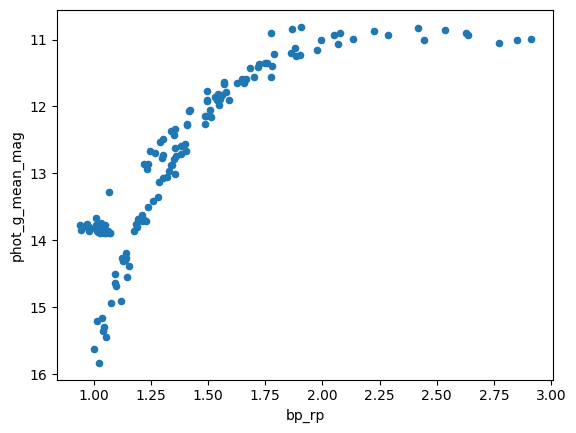

In [5]:
df_rc6[mask_ruwe].plot.scatter(x="bp_rp", y="phot_g_mean_mag")
plt.gca().invert_yaxis()


## $\omega$ Centauri - (Häberle et al., 2024)

In [6]:
Gaia.ROW_LIMIT = -1
results = get_cluster("ngc5139", rc_scale=1.0)
results6 = get_cluster("ngc5139", rc_scale=6.0)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
df_rc1 = results.to_pandas()
df_rc6 = results6.to_pandas()

print(f"Rc1: {df_rc1.shape[0]} elementos")
print(f"Rc6: {df_rc6.shape[0]} elementos")

df_rc1["RUWE_np5"] = get_ruwe_from_gaia(df_rc1, 5)
df_rc1["RUWE_np6"] = get_ruwe_from_gaia(df_rc1, 6)

df_rc6["RUWE_np5"] = get_ruwe_from_gaia(df_rc6, 5)
df_rc6["RUWE_np6"] = get_ruwe_from_gaia(df_rc6, 6)

Rc1: 4694 elementos
Rc6: 169556 elementos


In [26]:
columns = ["solution_id", "DESIGNATION", "SOURCE_ID", "ra", "dec", "parallax", 'pm', 'phot_g_mean_mag', "bp_rp", "RUWE_np5"]

mask_error = (df_rc1.pmra_error < 0.08) & (df_rc1.pmdec_error < 0.08) & (df_rc1.parallax_error < 0.08)

df_stars = df_rc1.loc[(~df_rc1["RUWE_np5"].isna()) & mask_error, columns].sort_values("pm", ascending=False)
df_stars[df_stars.pm >= 4.41]

,solution_id,DESIGNATION,SOURCE_ID,ra,dec,parallax,pm,phot_g_mean_mag,bp_rp,RUWE_np5
3868,1636148068921376768,Gaia DR3 6083701705983015552,6083701705983015552,201.645480,-47.471060,0.112714,9.569691,12.346845,1.523997,2.186182
2182,1636148068921376768,Gaia DR3 6083698854124839040,6083698854124839040,201.734598,-47.487699,0.195634,9.202696,11.529737,1.589243,1.142572
4455,1636148068921376768,Gaia DR3 6083701912141565184,6083701912141565184,201.744183,-47.458259,0.236299,9.075792,12.154989,1.503436,1.178013
1928,1636148068921376768,Gaia DR3 6083698755345479040,6083698755345479040,201.723194,-47.497283,0.162147,9.073417,11.830122,1.546110,1.150281
3532,1636148068921376768,Gaia DR3 6083702122622928384,6083702122622928384,201.691024,-47.445567,0.207204,8.819277,11.378763,1.660378,1.192588
...,...,...,...,...,...,...,...,...,...,...
547,1636148068921376768,Gaia DR3 6083701744642624768,6083701744642624768,201.684531,-47.490085,0.043815,5.995595,13.038641,1.334392,1.010006
1132,1636148068921376768,Gaia DR3 6083698819765087360,6083698819765087360,201.723363,-47.486186,0.171511,5.910168,11.710671,1.545373,1.158437
1009,1636148068921376768,Gaia DR3 6083702015220693504,6083702015220693504,201.671219,-47.474534,0.232812,5.909645,12.796445,1.350639,0.878023
2905,1636148068921376768,Gaia DR3 6083701637263545472,6083701637263545472,201.650933,-47.478784,0.063748,5.874531,13.124449,1.296809,1.298483


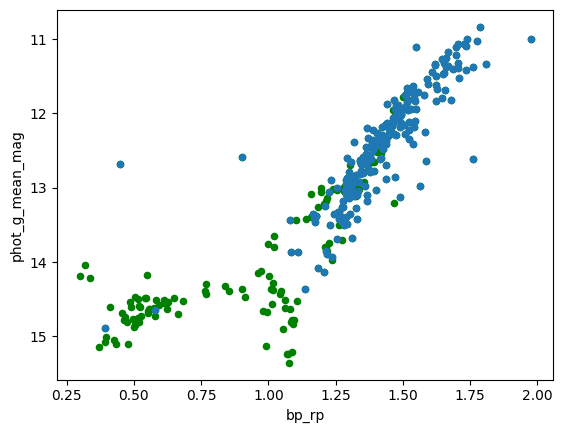

In [38]:
ax = df_rc1[~df_rc1["RUWE_np5"].isna()].plot.scatter(x="bp_rp", y="phot_g_mean_mag", color="green")
df_stars[df_stars.pm >= 4.41].plot.scatter(ax=ax,x="bp_rp", y="phot_g_mean_mag")
plt.gca().invert_yaxis()

In [14]:
df_rc1.pm

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4689    8.386451
4690    7.326908
4691         NaN
4692    7.665855
4693         NaN
Name: pm, Length: 4694, dtype: float32

In [41]:
results.columns

<TableColumns names=('solution_id','DESIGNATION','SOURCE_ID','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pm','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','nu_eff_used_in_astrometry','pseudocolour','pseudocolour_error','ra_pseudocolour_corr','dec_pseudocolour_corr','parallax_pseudocolour_corr','pmra_pseudocolour_corr','pmdec_pseudocolour_corr','astrometric_matched_transits','visibility_periods_used','astrometric_sigma5d_max','matched_transits','new_matched_transits','matched_transits_removed','ip